***LSTM using PyTorch***

This example illustrates the implementation of Long Short Term Memory Networks (LSTM) in PyTorch. Here the LSTM model is build to predict the total number of passengers in flights. The first step consist of importing the PyTorch libraries and other necessary packages. The dataset used for this problem is an in an inbuilt dataset from Seaborn known as *flights*. This dataset contains 12 years of monthly airline passenger statistics that begins in January 1949 and finishes in December 1960. Also, the total size of the dataset is 144.



**Importing packages**

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Parameters of the experiment
test_data_size = 30
seq_length = 4
num_epochs = 500
learning_rate = 0.001

input_size = 1
hidden_size = 100
num_layers = 1
num_classes = 1
batch_size = 16

**Loading dataset**

In [3]:
data = sns.load_dataset("flights")
print(data.shape)
data.tail()


(144, 3)


,year,month,passengers
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390
143,1960,Dec,432


Here we plot the total number of passengers against the months travelled by them. The plot shows a clear seasonal pattern and growing trend. Seasonality is a property of a time series in which the data goes through predictable and recurring changes on a yearly basis.

**Visualizing the data**

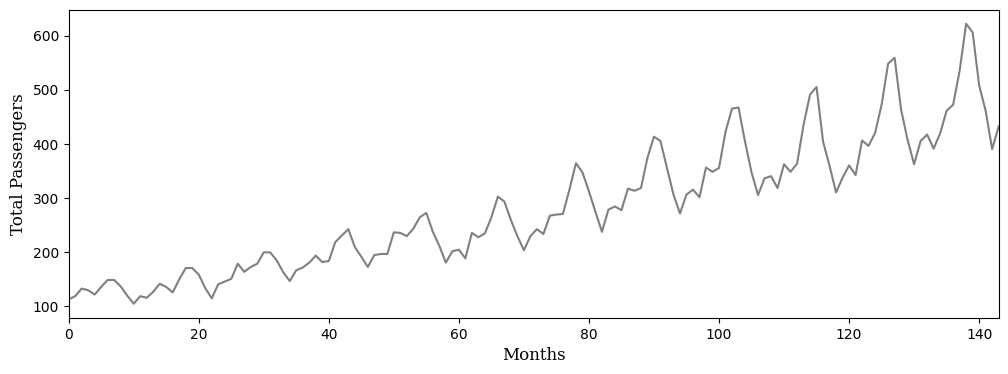

In [4]:
plt.figure(figsize=(12,4))
csfont = {'fontname':'serif'}
plt.plot(data['passengers'],color='Grey')
plt.xlabel('Months',fontsize=12,**csfont)
plt.ylabel('Total Passengers',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
plt.show()

In this step the passenger data is extracted and divided into training and test. Following this feature normalization is performed using the MinMaxScaler() function.

In [5]:
y_t = data['passengers'].values.astype(float)

train_data_size = len(y_t)-test_data_size
train_data = y_t[:-test_data_size]
test_data = y_t[-test_data_size:]
train_data=train_data.reshape(-1, 1)
test_data=test_data.reshape(-1, 1)

sc = MinMaxScaler(feature_range = (0, 1))
training_data = sc.fit_transform(train_data)
testing_data = sc.transform(test_data)

Here we define the sliding window for scaning the training and test data. We split the training sequence into overlapping windows while developing the LSTM models. For example, if we have a sequence with 16 samples and a window size of 4, we can enter [x1, x2, x3, x4] into the model and compare the forecast to x5. Next we input [x2, x3, x4, x5] into the model and match the forecast to x6 and the process goes on. The sliding window is defined using a function that input the data and the sequence length. The output of the function returns the sequence and the corresponding labels.

**Define the sliding window**

In [6]:
def sliding_windows(data, window_length):
    x = []
    y = []
    for i in range(len(data)-window_length):
        _x = data[i:(i+window_length)]
        _y = data[i+window_length]
        x.append(_x)
        y.append(_y)
        A=np.shape(x)
    return np.reshape(x,(A[0], A[1], A[2])), y


x, y = sliding_windows(training_data, seq_length)
x1, y1 = sliding_windows(testing_data, seq_length)
trainX = Variable(torch.Tensor(np.array(x)))
trainY = Variable(torch.Tensor(np.array(y)))
testX = Variable(torch.Tensor(np.array(x1)))
testY = Variable(torch.Tensor(np.array(y1)))


train_dataset = TensorDataset(trainX, trainY)
test_dataset  = TensorDataset(testX, testY)

train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)
print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)

torch.Size([110, 4, 1]) torch.Size([110, 1])
torch.Size([26, 4, 1]) torch.Size([26, 1])


In [7]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = ula[:, -1, :]

        out = self.fc(h_out)

        return out

In the training, we construct a for loop for performing the gradient descent and backpropagation. In the first step we compute the forward pass through the network by applying the model to the training examples. Next the loss is calculated based on the defined loss function, which compares the model output to the actual training labels. The .backward() function is used to backpropagate the derivative of the loss with respect to the model parameters through the network. After setting the current parameter gradients to zero with .zero_grad(), we update the model parameters by subtracting the gradient times the learning rate. This is done with the optimiser, using optimiser.step(). Here we use the Adam optimizer and mean square error loss for optimization.

**Training of the LSTM**

In [8]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
print(lstm)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
loss_curve=[]

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    loss_total = 0
    outputs = lstm(images)
    optimizer.zero_grad()
    loss = criterion(outputs, labels)
    loss_total += loss.item()
    loss.backward()

    optimizer.step()
  loss_curve.append(loss_total)
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

LSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
Epoch: 0, loss: 0.51703
Epoch: 100, loss: 0.01588
Epoch: 200, loss: 0.01107
Epoch: 300, loss: 0.01010
Epoch: 400, loss: 0.00941


**Plotting the loss curve for the training data**

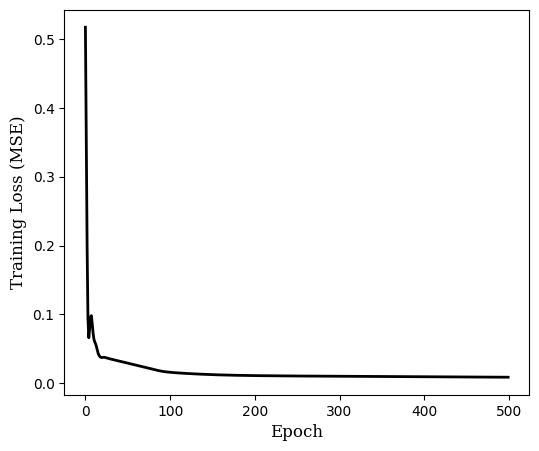

In [9]:
plt.figure(figsize=(6,5))
csfont = {'fontname':'serif'}
plt.plot(loss_curve, lw=2,color='k')
plt.xlabel("Epoch",fontsize=12,**csfont)
plt.ylabel("Training Loss (MSE)",fontsize=12,**csfont)
plt.show()

**Predictions on the test data**

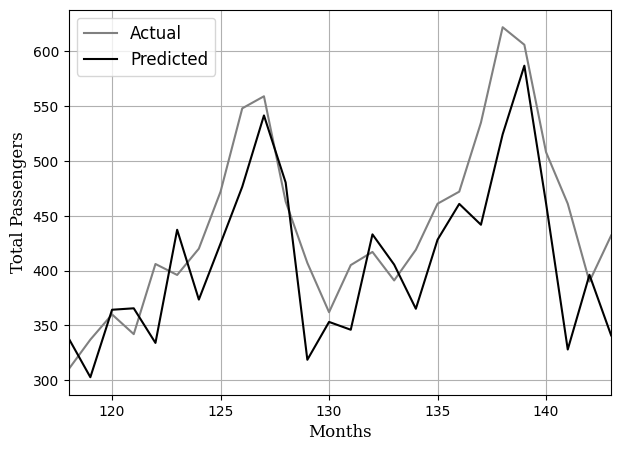

In [10]:
lstm.eval()
test_predict = lstm(testX)
data_predict = test_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(7,5))
x = np.arange(118, 144, 1)
csfont = {'fontname':'serif'}
plt.plot(x,dataY_plot,color='Grey',label='Actual')
plt.plot(x,data_predict,color='Black',label='Predicted')
plt.xlabel('Months',fontsize=12,**csfont)
plt.ylabel('Total Passengers',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
plt.grid()
plt.legend(fontsize=12)
plt.show()
